In [191]:
import torch, time, pickle, os, sys, argparse, corner
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os.path as osp

def convert(d,p):
    dfin=[]
    if len(p)!=len(np.unique(p)):
        print('Wrong order of prog/desc')
    else:
        no=d[0]
        for desc in d:
            if desc==no:
                dfin.append(0)
            else:
                dfin.append(p.index(desc)+1)
    return dfin, np.arange(1, 1+len(p))

def create_graphs(zcut=0, tcols=[0,2,4,5,6,7,8,10,28], target=8, lim=10, save=True, case='test', transform='standard', maxs=[1,1,1]):
    dat=[]
    tcols=np.array(tcols)
    raw_path=osp.expanduser('~/../../../tigress/cj1223/merger_trees/isotrees/')
    target_path=osp.expanduser('~/../../../tigress/cj1223/merger_trees/samout/')
    if transform:
        transform_path=osp.expanduser(f"../../../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_allfeat.pkl")
        scaler=pickle.load(open(transform_path, 'rb'))
    not_include=np.array([0,1,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,0,0,0,0]) 
    is_cat=[0,1,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,0,0,0,0]
    is_cat=np.array([bool(i) for i in is_cat])
    icols=np.array([1,3])
    load_cols=np.sort(np.concatenate([tcols,icols]))
    not_include=not_include[load_cols]
    meta={'tcols':tcols,
         'transform':transform,
         'target': target,
         'maxs':maxs}
    for i in range(0, maxs[0]):
        for j in range(0,maxs[1]):
            for k in range(0, maxs[2]):
                start=time.time()
                print(f'Loading isotree {i}_{j}_{k}')
                pd1=pd.read_table(raw_path+f'isotree_{i}_{j}_{k}.dat', skiprows=0, delimiter='\s+', usecols=load_cols)
                print(f'isotree {i}_{j}_{k} loaded, restructuring')
                
                raw=pd1.drop(axis=0, index=np.arange(50)).reset_index()
                del pd1
                
                trees=raw[raw.isna()['desc_id(3)']] 
                halos=raw[~raw.isna()['desc_id(3)']]
                del raw
                
                ##########################################
                ### End loading, begin dtype changing  ###
                ##########################################
                
                mask=halos.dtypes.values[1:]=='O'

                f,it="float64", "int64"
                map1=[]
                map2=[]
                q=0
                for l in load_cols:
                    q+=1
                    if l<25:
                        map1.append(l)
                        map2.append(q)
                map1=np.array(map1)
                map2=np.array(map2)

                castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f])

                castto=castto[map1]
                dicts = {}
                keys = halos.columns[map2]
                for d, key in enumerate(keys):
                        dicts[key] = castto[d]

                halos=halos.astype(dicts)
                
                ###################################################
                ### end dtype, z-selection                      ###
                ###################################################
                
                
                
                mask=(1/halos['#scale(0)']-1)>=zcut
                zhalos=halos[mask]
                acuts_true=np.unique(zhalos['#scale(0)'])
                acut_true=np.unique(zhalos['#scale(0)'])[-1]
                zcut_true=1/acut_true-1
                zhalos['desc_id(3)'][zhalos['#scale(0)']==acut_true]=-1
                meta['zcut']=[zcut,zcut_true]
                #########################################################
                ### end z-selcetion, begin inital hardcoded scaling   ###
                #########################################################
                

                log=[10,38, 39, 40, 41, 42]
                #simple log for the rest
                def logt(x):
                    return np.log10(x+1)
                for l in log:
                    if l in tcols:
                        l1=np.where(load_cols==l)[0][0]+1
                        zhalos[zhalos.columns[l1]]=logt(zhalos[zhalos.columns[l1]])

                scale_cols=np.array(tcols[~is_cat[tcols]])
                meta['scale_cols']=scale_cols
                #########################################################
                ### end inital hardcoded scaling, begin split/scale   ###
                #########################################################
                
                indices = [i for i, x in enumerate(zhalos['desc_id(3)']) if x == -1]
                print(f'Splitting to tree and scaling')
                spli=np.split(np.array(zhalos)[:,1:], np.array(indices[1:]))
                # del zhalos, halos
                splits=[]
                for s in spli:
                    if s[0,np.where(load_cols==10)[0][0]]>lim:
                        splits.append(s)
                splits=np.array(splits, dtype=object)
                split=[]
                for tree in splits:
                    s=tree[np.logical_or(tree[:,3] == -1,tree[:,4]!=1)]
                    if transform:
                        for n in scale_cols:
                            n1=np.where(load_cols==n)[0][0]
                            s[:,n1]=scaler[n].transform(s[:,n1].reshape(-1,1)).reshape(np.shape(s[:,n1])) #this needs to change
                    split.append(s)
                split=np.array(split, dtype=object)
                print('Split done')
                
                #########################################################
                ### end split, begin target loading                   ###
                #########################################################
                
                del zhalos
                
                print('Loading targets')
                ex=f'{i}_{j}_{k}/galprop_0-99.dat'
                pdc=pd.read_table(target_path+ex, skiprows=0, delimiter=',', nrows=41, header=None)
                newcols=pdc.iloc[:,0]
                pds=pd.read_table(target_path+ex, skiprows=41, delimiter='\s+', header=None)
                pds.columns=np.array(newcols)
                
                #########################################################
                ### end target loading, begin z-cut                   ###
                #########################################################
                
                zcut_SAM=np.unique(pds[pds.columns[3]])[np.isclose(np.unique(pds[pds.columns[3]]),zcut_true)][0]
                pdz=pds[pds[pds.columns[3]]==zcut_SAM] # redshift selection for selecting final halos
                pdcen=pdz[(pdz[pds.columns[4]]==0)] ##central haloes

                del pdz

                rhalid=np.array(pdcen[pds.columns[1]])
                halwgal=[] ##scaled
                ids=[]
                out=[]
                for idx, tree in enumerate(split): #split up into tree
                    if tree[0,1] in rhalid:
                        if len(tree)>20000:
                            print(len(tree))
                        else:
                            halwgal.append(tree) ##scaled
                            ids.append(idx)
                            index=np.where(rhalid==tree[0,1])
                            out.append(np.array(pdcen.iloc[index])[0][target]) ## target variable column


                hraw=np.array(splits[ids], dtype=object) ##unscaled
                
                
                del pdcen
                del pds

                hraw=np.array(splits[ids], dtype=object)
                hals=[]
                pr,de=[],[]
                discards=[]
                ids=[]
                print('Making merger tree')
                for n in tqdm(range(len(halwgal))):
                    h=halwgal[n]
                    roots=h[h[:,4]==0]
                    mergers=h[h[:,4]>1]
                    final=h[h[:,3]==-1]
                    pro, des=[],[]
                    discarded=[]
                    for mid in mergers[:,1]:
                        k=1
                        descid=hraw[n][:,3][np.where(mid==hraw[n][:,1])] ##descendant ID of raw where the id of the merger is
                        while descid not in mergers[:,1] and descid!=-1: 
                            k+=1
                            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]
                        pro.append(mid)
                        if descid!=-1:
                            des.append(descid[0])
                        else:
                            des.append(hraw[n][:,3][np.where(mid==hraw[n][:,1])][0])
                        discarded.append(1/k) 

                    for r in roots:
                        descid=hraw[n][:,3][np.where(r[1]==hraw[n][:,1])] 
                        k=1
                        while descid not in mergers[:,1] and descid!=[-1]: ##could add 1/k
                            k+=1
                            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]#consider adding the number of steps it went through
                        pro.append(r[1])
                        if descid!=-1:
                            des.append(descid[0])
                        else:
                            des.append(hraw[n][:,3][np.where(r[1]==hraw[n][:,1])][0])
                        discarded.append(1/k) 

                    discards.append(np.array(discarded))
                    des,pro=convert(des, pro)
                    hal2=np.vstack([final,mergers,roots])
                    # global mass_index
                    if n==0:
                        fcols=[i for i in range(len(hal2[0])) if not_include[i]==0] ##choose non-id cols to carry forward
                    hal2=hal2[:,fcols] ##take away id's
                    hals.append(hal2)
                    pr.append([int(p) for p in pro])
                    de.append([int(d) for d in des])
                    ids.append(hal2[:,[1,3]])
                meta['ids']=ids
                hals=np.array(hals,dtype=object)
                out=np.array(out)
                outtrans=[]
                for i in range(len(out[0])):
                    pl=np.log10(out[:,i])
                    if min(pl) == -np.inf:
                        outtrans.append(np.log10(out[:,i]+1))
                    else:
                        outtrans.append(np.log10(out[:,i]))
                out=np.array(outtrans).T
                for n in tqdm(range(len(out))):
                    edge_index = torch.tensor([pr[n],de[n]], dtype=torch.long)
                    x = torch.tensor(hals[n], dtype=torch.float)
                    y=torch.tensor(out[n], dtype=torch.float)
                    edge_attr=torch.tensor(discards[n], dtype=torch.float)
                    graph=Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
                    dat.append(graph)
                stop=time.time()
                print(f'Done with tree. \n Time elapsed {stop-start} s')
    if save:
        case=case+f'_z{zcut_true:.1f}_{transform}'
        print("Saving dataset")
        if not osp.exists(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}'):
            os.mkdir(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}')

        with open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'wb') as handle:
            pickle.dump(dat, handle)
        with open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/meta.pkl', 'wb') as handle:
            pickle.dump(meta, handle)
    return dat

In [192]:
all_cols=np.array([0,2,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,35]+list(range(37,60)))
data=create_graphs(zcut=0, tcols=all_cols, maxs=[1,1,1], target=[8,11,14,15,16,17,18,23], case='test_multi', transform=None)

Loading isotree 0_0_0


/tmp/ipykernel_24950/85237137.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  data=create_graphs(zcut=0, tcols=all_cols, maxs=[1,1,1], target=[8,11,14,15,16,17,18,23], case='test_multi', transform=None)


isotree 0_0_0 loaded, restructuring


/tmp/ipykernel_24950/1918751355.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zhalos['desc_id(3)'][zhalos['#scale(0)']==acut_true]=-1


Splitting to tree and scaling
Split done
Loading targets
Making merger tree


100%|██████████████████████████████████████████████████████████████████| 770/770 [00:59<00:00, 12.97it/s]
/tmp/ipykernel_24950/1918751355.py:237: RuntimeWarning: divide by zero encountered in log10
  pl=np.log10(out[:,i])
100%|███████████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 13242.69it/s]


Done with tree. 
 Time elapsed 128.49722170829773 s
Saving dataset


In [193]:
outs=[]
target=[8,11,14,15,16,17,18,23]
for d in data:
    outs.append(d.y.numpy())
outs=np.array(outs)

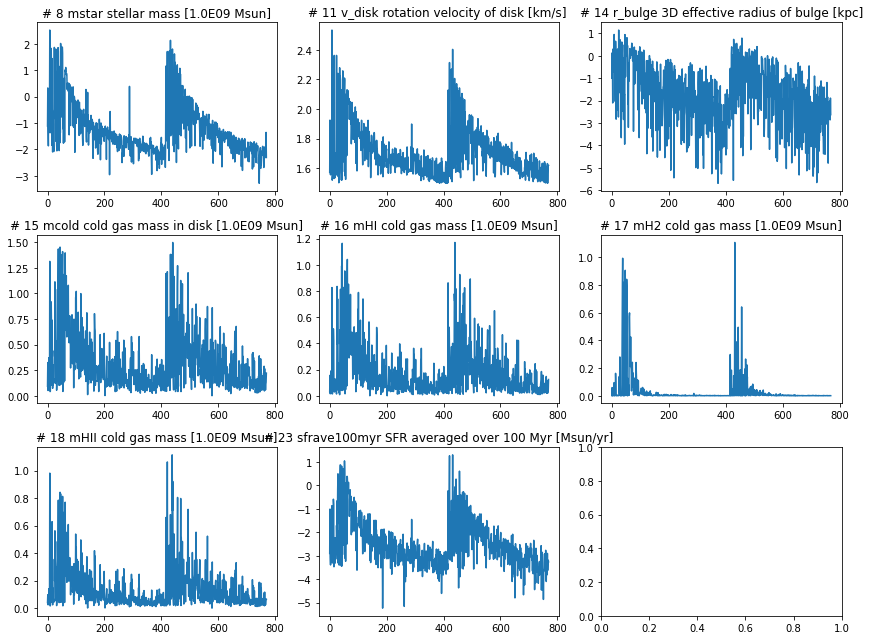

In [194]:
# outtrans=[]
fig, ax = plt.subplots(3,3, figsize=(12,9))
ax=ax.flatten()
for i in range(len(outs[0])):
    ax[i].plot(outs[:,i])
#         outtrans.append(np.log10(outs[:,i]))
    ax[i].set(title=pdcen.columns[target[i]])
# outtrans=np.array(outtrans)
fig.tight_layout()

In [179]:
outtrans=[]
for i in range(len(out[0])):
    pl=np.log10(outs[:,i])
    if min(pl) == -np.inf:
        outtrans.append(np.log10(outs[:,i]+1))
    else:
        outtrans.append(np.log10(outs[:,i]))


array([[7.70348e-02, 3.73807e+01, 9.90288e-02, ..., 2.20696e-03,
        9.90337e-02, 1.26210e-03],
       [2.13686e+00, 8.41900e+01, 1.34010e+00, ..., 1.45516e-01,
        2.50530e-01, 9.71273e-02],
       [6.68119e-02, 3.74219e+01, 4.07950e-01, ..., 3.09514e-04,
        5.68448e-02, 9.39755e-04],
       ...,
       [5.46377e-03, 3.93400e+01, 1.36559e-03, ..., 1.85394e-03,
        7.83552e-02, 5.01545e-04],
       [4.42024e-02, 4.17545e+01, 1.28234e-02, ..., 1.13673e-03,
        1.66706e-01, 6.45005e-04],
       [4.93747e-03, 4.16400e+01, 2.33262e-03, ..., 9.90703e-04,
        1.61670e-01, 5.46207e-04]], dtype=float32)

/tmp/ipykernel_24950/3346628145.py:5: RuntimeWarning: divide by zero encountered in log10
  pl=np.log10(outs[:,i])
/tmp/ipykernel_24950/3346628145.py:5: RuntimeWarning: divide by zero encountered in log10
  pl=np.log10(outs[:,i])
/tmp/ipykernel_24950/3346628145.py:5: RuntimeWarning: divide by zero encountered in log10
  pl=np.log10(outs[:,i])
/tmp/ipykernel_24950/3346628145.py:5: RuntimeWarning: divide by zero encountered in log10
  pl=np.log10(outs[:,i])


# 15 mcold cold gas mass in disk [1.0E09 Msun]
# 16 mHI cold gas mass [1.0E09 Msun]
# 17 mH2 cold gas mass [1.0E09 Msun]
# 18 mHII cold gas mass [1.0E09 Msun]


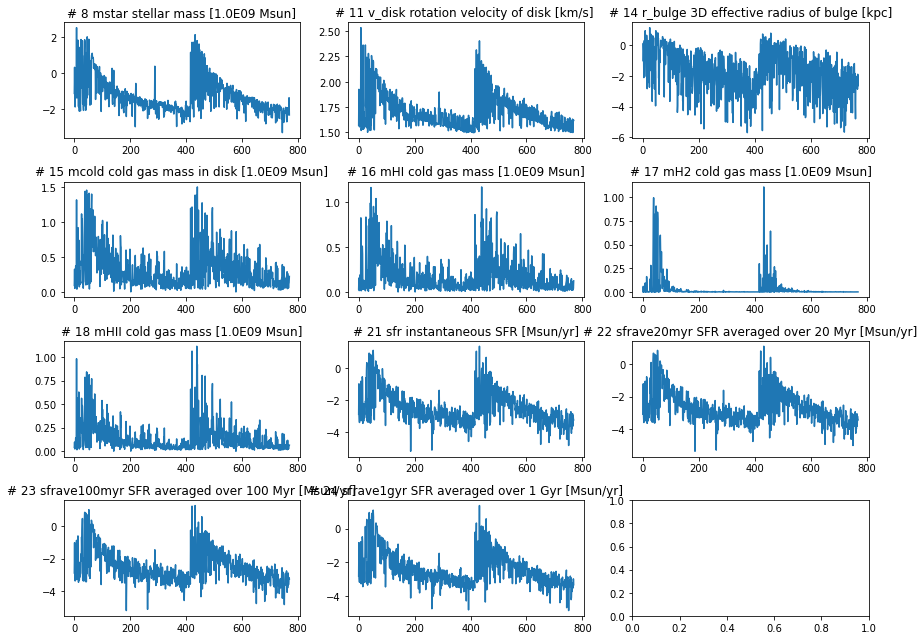

In [112]:
outtrans=[]
fig, ax = plt.subplots(4,3, figsize=(12,9))
ax=ax.flatten()
for i in range(len(outs[0])):
    pl=np.log10(outs[:,i])
    if min(pl) == -np.inf:
        print(pdcen.columns[target[i]])
        ax[i].plot(np.log10(outs[:,i]+1))
        outtrans.append(np.log10(outs[:,i]+1))
    else:
        ax[i].plot(np.log10(outs[:,i]))
        outtrans.append(np.log10(outs[:,i]))
    ax[i].set(title=pdcen.columns[target[i]])
outtrans=np.array(outtrans)
fig.tight_layout()

In [113]:
vals, counts=np.unique(outs[:,4], return_counts=1)

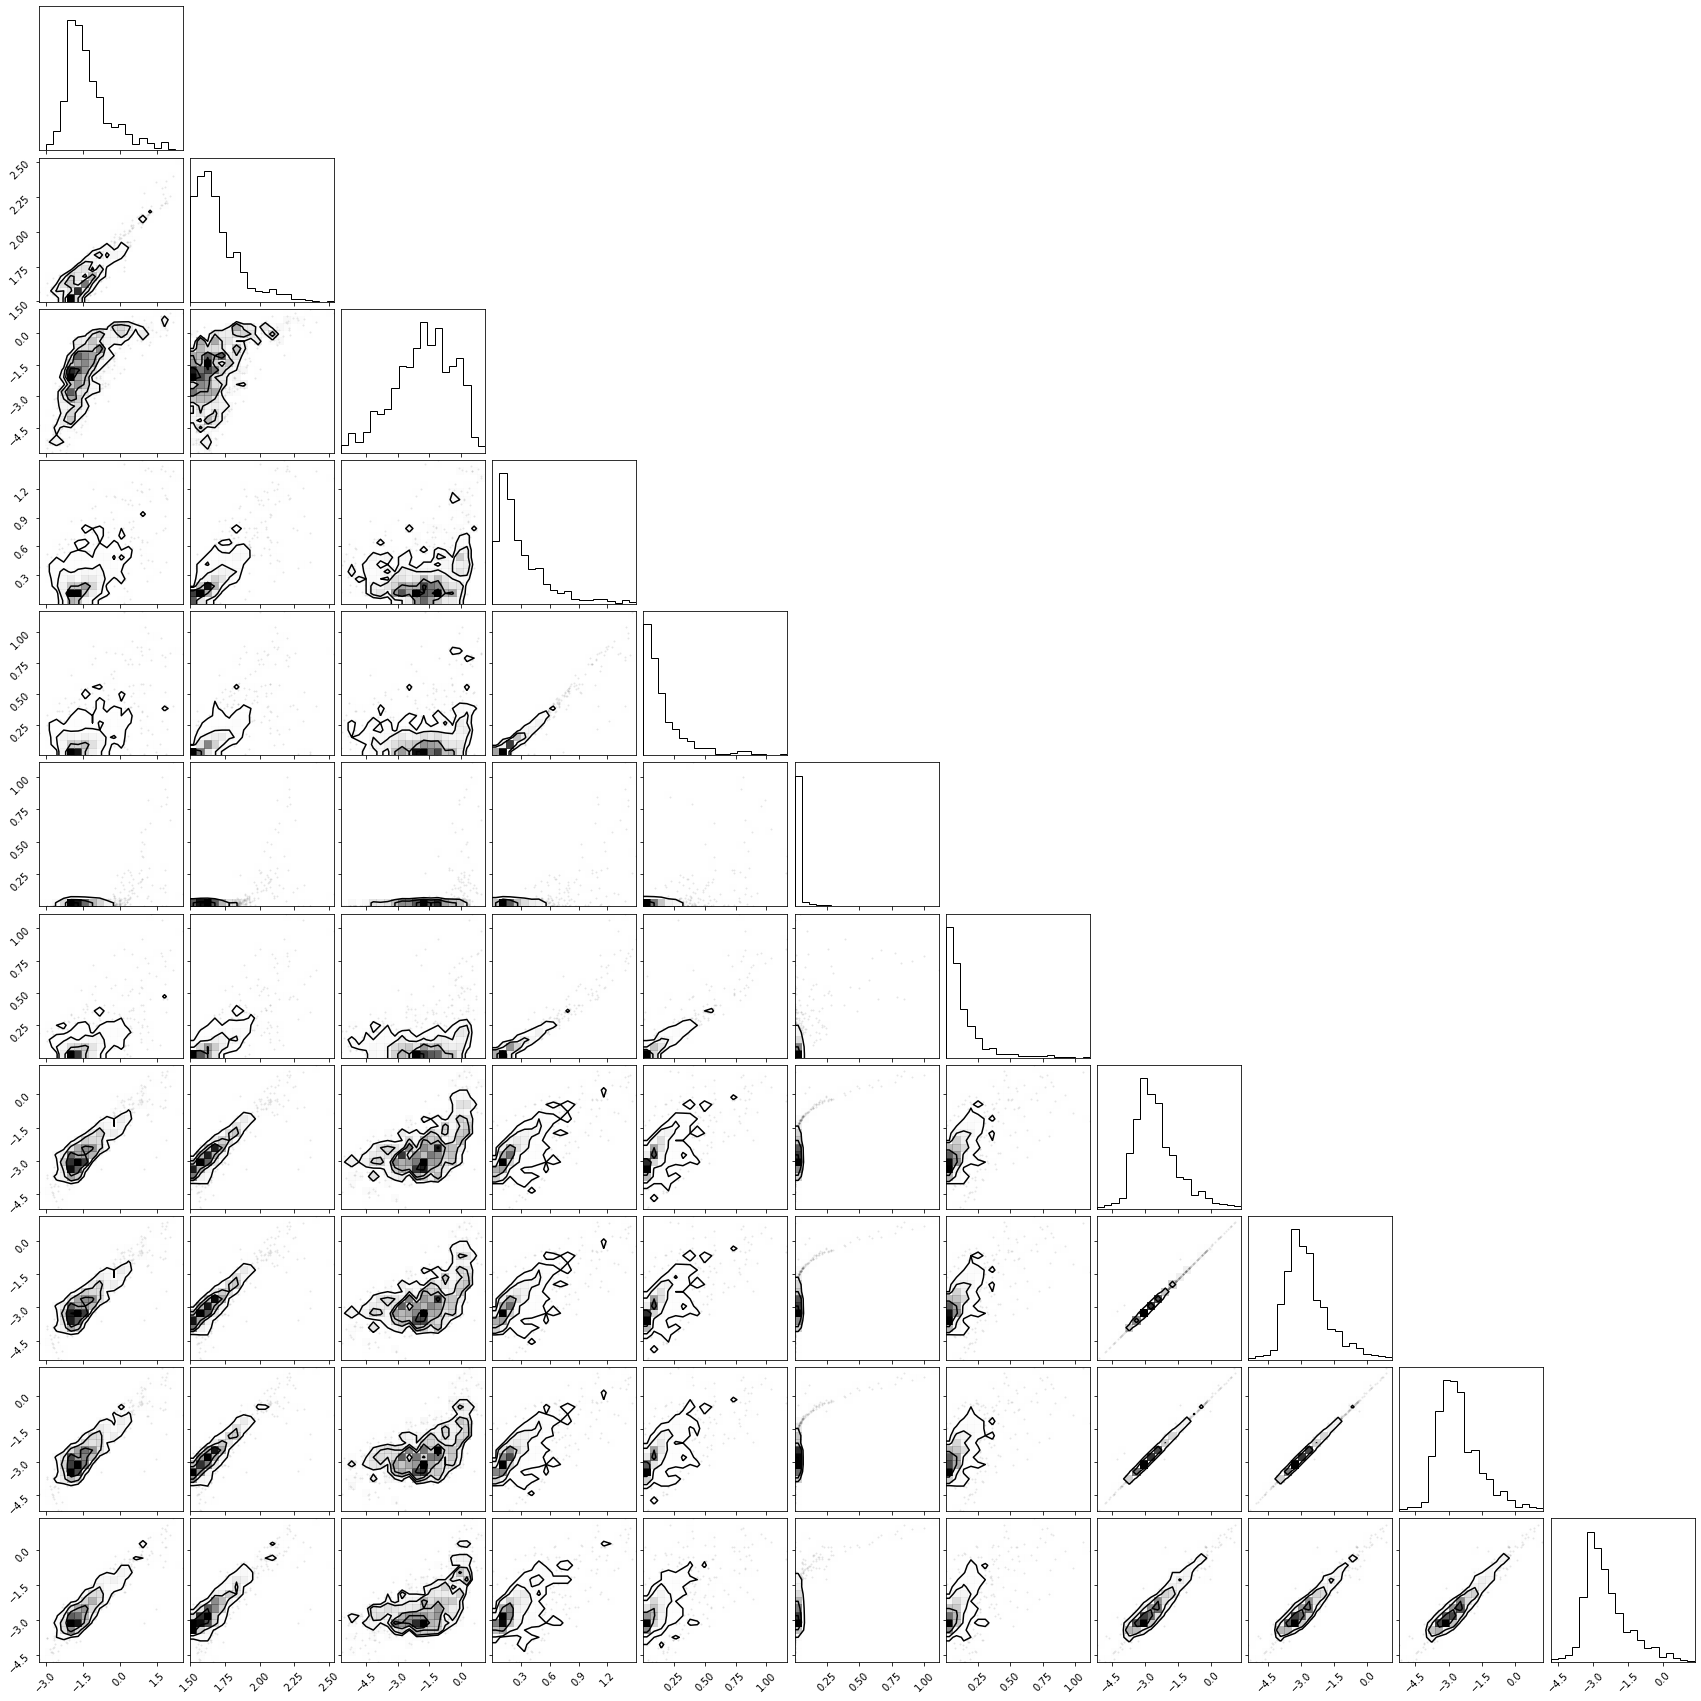

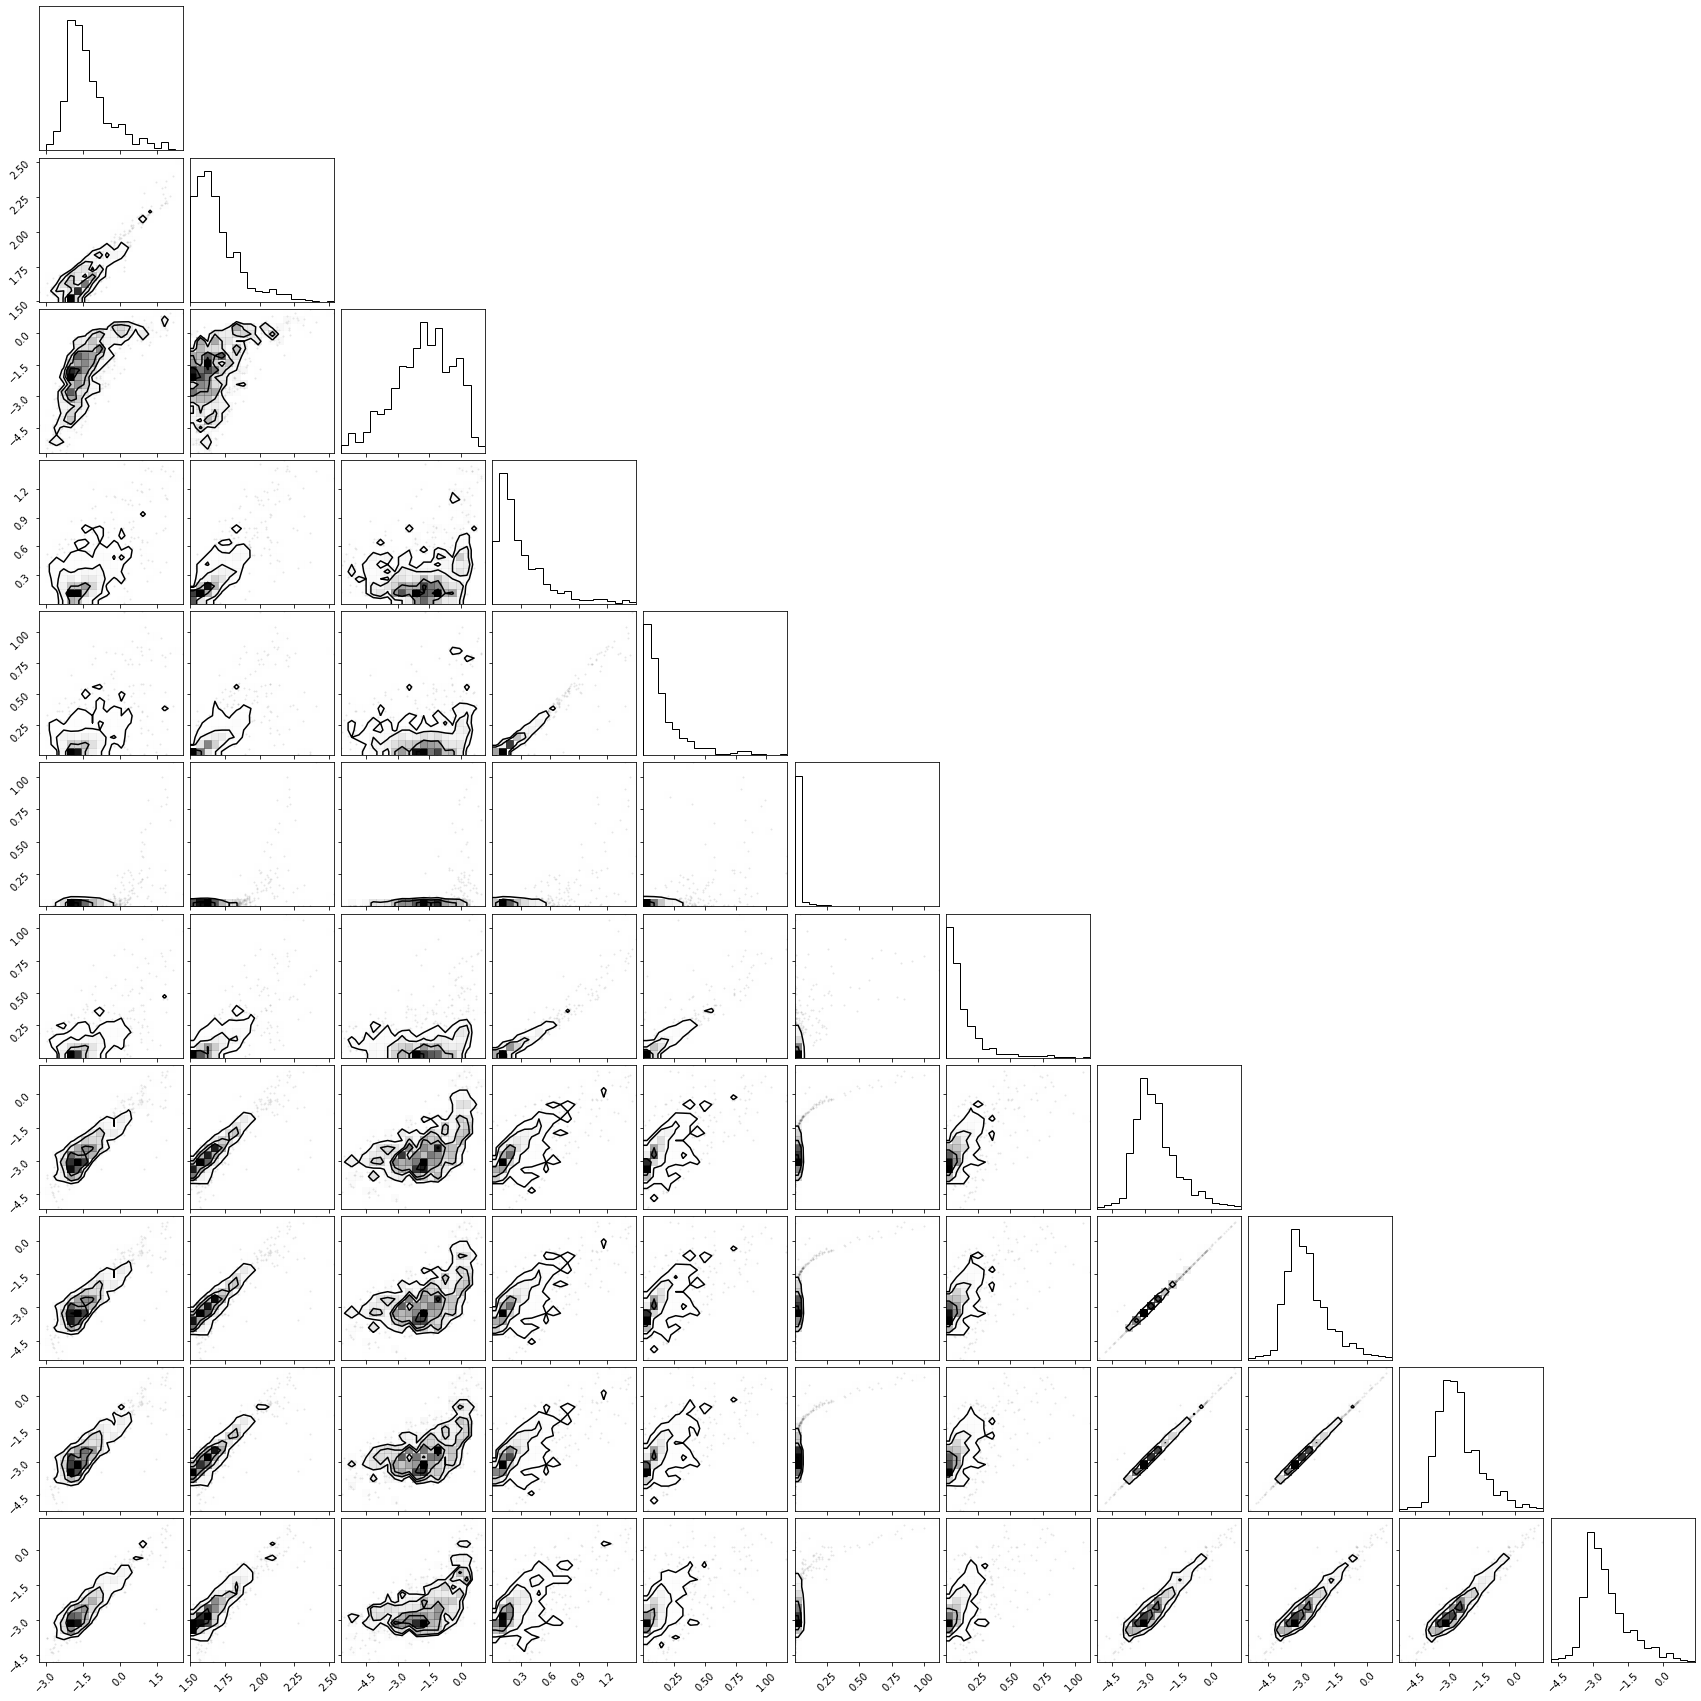

In [114]:
corner.corner(np.array(outtrans).T)

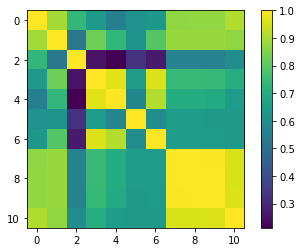

In [119]:
plt.imshow(np.corrcoef(outtrans))
plt.colorbar()

In [116]:
pdcen.columns[target]

Index(['# 8 mstar stellar mass [1.0E09 Msun]',
       '# 11 v_disk rotation velocity of disk [km/s] ',
       '# 14 r_bulge 3D effective radius of bulge [kpc]',
       '# 15 mcold cold gas mass in disk [1.0E09 Msun]',
       '# 16 mHI cold gas mass [1.0E09 Msun]',
       '# 17 mH2 cold gas mass [1.0E09 Msun]',
       '# 18 mHII cold gas mass [1.0E09 Msun]',
       '# 21 sfr instantaneous SFR [Msun/yr]',
       '# 22 sfrave20myr SFR averaged over 20 Myr [Msun/yr]',
       '# 23 sfrave100myr SFR averaged over 100 Myr [Msun/yr]',
       '# 24 sfrave1gyr SFR averaged over 1 Gyr [Msun/yr]'],
      dtype='object')

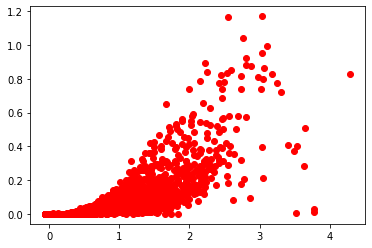

In [120]:
plt.plot(np.log10(pdcen[pdcen.columns[5]]), np.log10(pdcen[pdcen.columns[16]]+1), 'ro')

In [122]:
np.log10(pdcen[pdcen.columns[16]]+1).max()

1.1702088925835439